In [1]:
%matplotlib inline
import scipy
import gempy as gp
import geopandas as gpd
import os
import pyvista 
import rasterio
from rasterio.plot import show
import gemgis as gg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyvista import set_plot_theme
import matplotlib.image as mpimg


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\morit\anaconda3\envs\gemgis\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Import Data

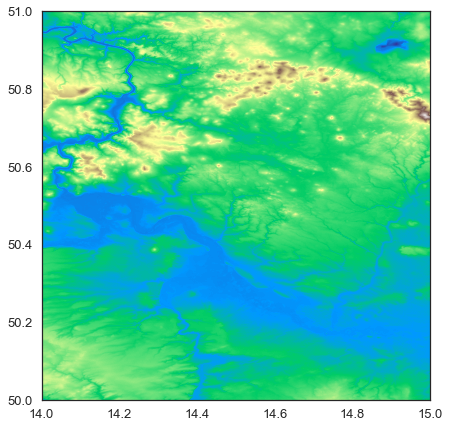

<AxesSubplot:>

In [2]:
#raw height-data from 'N50E014.hgt' file, source: https://data.europa.eu/data/datasets/dtm-germany?locale=en
data_path= 'https://raw.githubusercontent.com/Mo34843279347/Sandstone_Mountains/main/'
fp = r'N50E014.hgt'
img = rasterio.open(fp)
show(img, with_bounds=True, cmap='terrain')

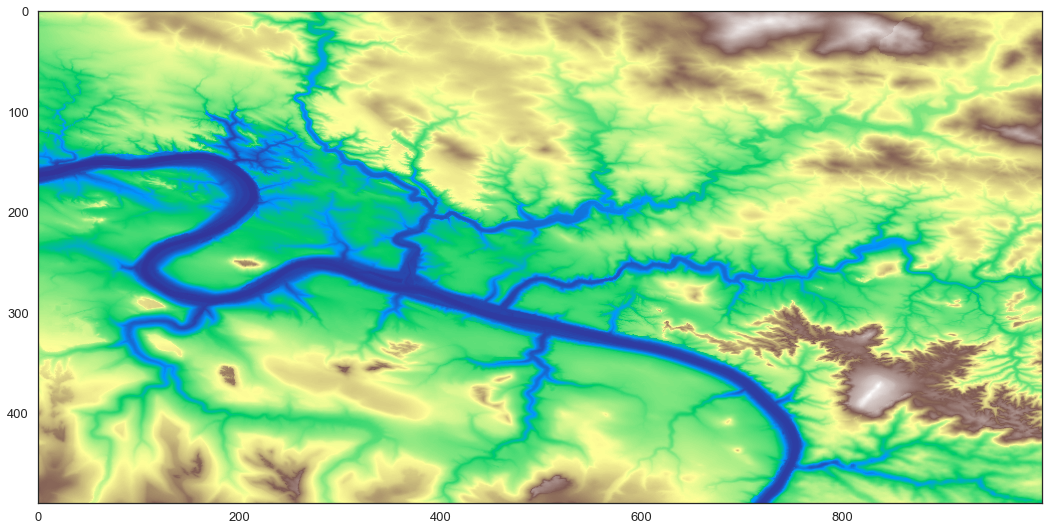

In [3]:
#select region of modell
raster = rasterio.open('N50E014.hgt')
raster_array= raster.read(1)
re_raster= raster_array[0:490, 99:1099]

fig, ax = plt.subplots(figsize=(18, 32))
ax.imshow(re_raster, cmap='terrain')



In [4]:
x_axis= np.linspace(14.02749236,14.305193,1000)
y_axis= np.linspace(50.86392669, 51,490)


In [5]:
raster_array

array([[240, 240, 239, ..., 306, 306, 306],
       [240, 239, 240, ..., 308, 308, 308],
       [238, 238, 239, ..., 310, 310, 309],
       ...,
       [243, 240, 237, ..., 257, 257, 258],
       [264, 262, 259, ..., 256, 256, 257],
       [279, 275, 271, ..., 257, 257, 257]], dtype=int16)

In [6]:
#problem with extent, np.shape(Raster_shaped.tif) = (3601,3601)

# gg.raster.save_as_tiff(raster=raster_array,
#                         path= 'Raster_shaped.tif',
#                         extent=[14.02749236, 14.305193,50.86392669,51],
#                         crs='EPSG:4326')


# Gempy

In [7]:
geo_model = gp.create_model('ES_model')
geo_model = gp.init_data(geo_model, extent=[0, 1000, 0, 490, -400, 500], resolution=[100, 10, 100],
                        path_o= data_path+ 'orientations.csv',
                        path_i= data_path+ 'surface_points.csv')
gp.set_interpolator(geo_model, theano_optimizer='fast_compile', verbose=[])
gp.plot_3d(geo_model, show_surfaces=False, show_data=True, show_lith=False, image=False)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                   values
range            1431.82
$C_o$           48811.90
drift equations   [3, 3]


In [8]:
gp.map_stack_to_surfaces(geo_model, {'Fault':'Fault'})
geo_model.reorder_features(['Fault','Default series', 'Basement'])

,order_series,BottomRelation,isActive,isFault,isFinite
Fault,1,Erosion,True,False,False
Default series,2,Erosion,True,False,False
Basement,3,Erosion,False,False,False


In [9]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
5,Fault,Fault,1,#ff3f20,1
0,surface1,Default series,1,#015482,2
1,surface2,Default series,2,#9f0052,3
2,surface3,Default series,3,#ffbe00,4
3,surface4,Default series,4,#728f02,5
4,surface5,Default series,5,#443988,6
6,basement,Basement,1,#5DA629,7


In [10]:
#set topography
geo_model.set_topography(source='gdal', filepath=data_path+'Raster.tif')
gp.set_interpolator(geo_model)
gp.compute_model(geo_model, compute_mesh=False, set_solutions=True)

gp.compute_model(geo_model)
geo_model.additional_data.kriging_data
geo_model.additional_data.rescaling_data

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1431.82
$C_o$             48811.90
drift equations  [3, 3, 3]


C:\Users\morit\anaconda3\envs\gemgis\lib\site-packages\gempy\core\solution.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.geological_map = np.array(


,values
rescaling factor,1998
centers,"[500.5, 1.0, 0.0]"


In [11]:
#show model
g3d = gp.plot_3d(geo_model,
                 plotter_type='background',
                 show_topography=True,
                 show_lith=True,
                 show_surfaces=True,
                 kwargs_plot_structured_grid={'opacity': .15},
                 ve=1, 
                 off_screen=False)

C:\Users\morit\anaconda3\envs\gemgis\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


In [12]:
# p3d= gp.plot_3d(geo_model, plotter_type='background', notebook=False)
# p3d.plot_topography(scalars='topography', contours=False)
# p3d.plot_topography()
#p3d.plot_structured_grid() #funktioniert nicht

# Cross section

C:\Users\morit\anaconda3\envs\gemgis\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


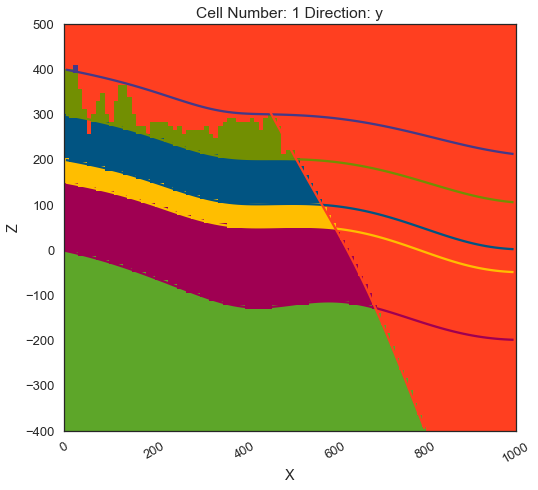

In [13]:
#gp.plot_2d(geo_model, cell_number=[9])
p2d= gp.plot_2d(geo_model, section_names= None, direction=None, cell_number=None)
ax= p2d.add_section(cell_number=1, direction='y')
p2d.plot_lith(ax, cell_number=1, direction='y')
p2d.plot_contacts(ax, cell_number=1)

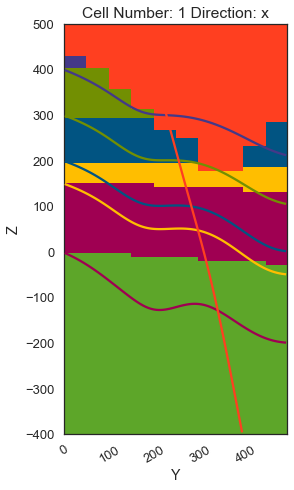

In [14]:
p2d= gp.plot_2d(geo_model, section_names= None, direction=None, cell_number=None)
ax= p2d.add_section(cell_number=1, direction='x')
p2d.plot_lith(ax, cell_number=1, direction='x')
p2d.plot_contacts(ax, cell_number=1)

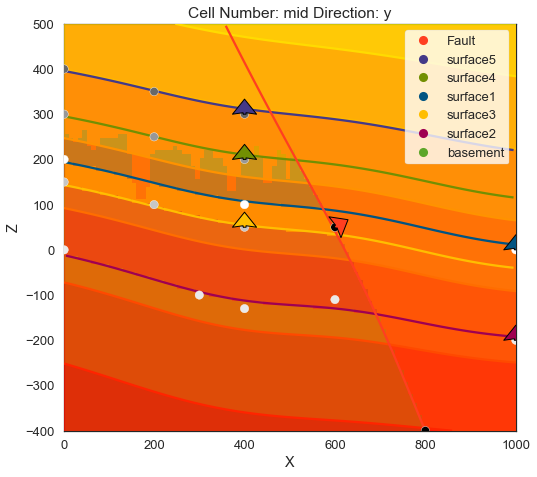

In [15]:
gp.plot_2d(geo_model, show_scalar=True, series_n=1)